# Redes Neuronales Artificiales & Deep Learning

## Objetivos de este curso

- **Conocer, entender y aplicar algunos modelos clásicos de Redes Neuronales Artificiales**, y algunas habilidades útiles en la práctica.
- **Conocer los conceptos básicos del Aprendizaje Profundo y aplicar las herramientas para desarrollar aplicaciones de machine learning**.
- **Aprender a utilizar los modelos de Deep Learning de Keras con la biblioteca Scikit-Learn de Python**, y evaluar los modelos de Keras utilizando la validación cruzada en scikit-learn (la biblioteca scikit-learn es la biblioteca más popular para Machine Learning en Python).
- **Identificar el tipo de red neuronal más adecuado para cada problema**, y las limitaciones de cada arquitectura.
- **Presentar a Python como herramienta de simulación de Redes Neuronales Artificiales**, y el ambiente de trabajo del curso!!!

## Schedule:

- Comenzando...
- Introducción
- Perceptrón
- Redes neuronales estáticas
- Redes recurrentes y mapas auto-organizados
- Memorias asociativas y Redes de funcion de base radial
- Introducción a las bibliotecas de aprendizaje profundo
- Modelos de regresión con Keras
- Modelos de clasificación con Keras
- Redes neuronales convolucionales (CNN)
- Redes neuronales recurrentes (RNN)

In [1]:
# Run this only in Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
colab_path = '/content/drive/My Drive/Colab Notebooks/deep-learning/notebooks/'
my_path = 'img/'
valid_path = colab_path # Use one of them depending on the platform

## Trabajando con imagenes propias

Al crear un modelo de clasificación lo normal es entrenarlo para nuestras propias necesidades, y por tanto con nuestras propias imagenes y etiquetas (categorias), o *dataset*, vamos a ver como hacer esto con un conjunto de imagenes de animales almacenadas en nuestro disco duro, en nuestro caso organizadas en tres categorias cada una en una carpeta, **el título de la carpeta es el nombre de la categoría**. Si trabaja con su propio conjunto de datos, ¡organícelo de la misma manera! Lo ideal es reunir 1.000 imágenes por clase como mínimo. Esto no siempre es posible, pero al menos debe tener un equilibrio de clases. Un número significativamente mayor de imágenes en una carpeta de clase podría causar sesgo en el modelo.

El siguiente es el directorio *test_ani*. Este directorio contiene tres imágenes para propósitos de prueba que usaremos para demostrar cómo (1) cargar un modelo entrenado desde el disco y luego (2) clasificar una imagen de entrada que no es parte de nuestro conjunto de datos original.

La carpeta *output* contiene tres tipos de archivos que son generados por el entrenamiento:

- .model : Se genera un archivo de modelo Keras serializado después del entrenamiento y puede ser usado en futuros scripts de inferencia.
- .pickle : Un archivo binario de etiquetas serializado. Este archivo contiene un objeto que contiene nombres de clase. Acompaña a un archivo modelo.
- .png : Las imágenes de la gráfica de entrenamiento/validación en la carpeta de salida, utiles cuando se esta evaluando un modelo, como resultado del proceso de entrenamiento.

En primer lugar, vamos a importar las librerías necesarias. Importaremos las librerías de numpy, TensorFlow (éste será el framework sobre el que correrá Keras), Keras y unas librerías necesarias Scikit Learn, Pandas, etc.

In [3]:
import numpy as np
from scipy import misc
from PIL import Image
import glob
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import cv2
import seaborn as sn
import pandas as pd
import pickle
from keras import layers
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import layer_utils, np_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model # Path modificado!
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from keras import losses
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

### Cargando el dataset desde nuestro disco duro

Las rutas de los archivos de entrada y salida las organizaremos de la siguiente forma:

- *dataset* ---> Ruta al conjunto de datos de entrada de imágenes.
- *model* ---> Ruta al modelo entrenado de salida.
- *label_bin* ---> Las etiquetas de los conjuntos de datos se serializan en el disco para facilitar su recuperación en otros scripts. Esta es la ruta al archivo binario de etiquetas de salida.
- *plot* ---> Ruta al archivo de imagen de la salida de entrenamiento.

Las imagenes se mezclaran aleatoriamente en la lista de datos para mejorar el desempeño de la red. Además, se redimensionan todas a un mismo tamaño, cuadrado en este caso (*norm_size* x *norm_size*), con el mismo objetivo. En este caso no se tiene en cuenta la relación de aspecto de las imagenes al re-dimensionarlas, pero esto se puede incluir, de hecho se puede hacer cualquier pre-procesamiento que se desee a las imagenes. Recordar ademas que el tamaño es importante para ciertas redes profundas.

In [ ]:
from imutils import paths
import random
import os

# Inicia datos de entrenamiento
dataset = [valid_path + 'animals'] # Carpeta con las imagenes de entrenamiento
output = [valid_path + 'model'] # Carpeta para guardar el modelo creado
images = [valid_path + 'test_ani'] # Carpeta con las imagenes de prueba
etique = [valid_path + 'label_bin'] # Carpeta con etiquetas de salida
curvas = [valid_path + 'plot'] # Carpeta con las imagenes de desempeño
norm_size = 32 # Nuevo tamaño para todas las imagenes, norm_size x norm_size pixeles
data = [] # Lista de datos, data list. Despues de llenada se convierte a arreglo de NumPy
labels = [] # Lista de etiquetas, label list. Despues de llenada se convierte a arreglo de NumPy
 
# Toma las rutas de las imagenes y las mezcla aleatoriamente
imagePaths = sorted(list(paths.list_images(dataset[0])))
random.seed(42)
random.shuffle(imagePaths)
 
# Bucle sobre las imágenes de entrada
for imagePath in imagePaths:
    # Cargar la imagen, preprocesarla y almacenarla en la lista de datos.
    # Nuevo tamaño para imagenes: norm_size x norm_size pixeles ignorando relacion de aspecto.
    # Aplana la imagen en las tres matrices de color, 32x32x3 y la almacena en la data list.
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (norm_size, norm_size)).flatten()
    #image = cv2.resize(image, (norm_size, norm_size))
    data.append(image)
 
    # Extracción de la etiqueta de la ruta de la imagen y actualización de la lista de etiquetas
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

*imutils* es una serie de funciones convenientes para hacer más fáciles las funciones básicas de procesamiento de imágenes como la traslación, rotación, redimensionamiento, esqueletización y visualización de imágenes en Matplotlib con OpenCV y Python. Se puede instalas con pip:

    pip3 install imutils

Lo que haremos a continuación, es normalizar las imágenes. Esto es, dividiremos cada elemento de *data* por el máximo valor de cada píxel, es decir, 255. Con esto se tendrá que el array comprenderá solo valores de entre 0 y 1, lo cual como ya se ha mencionado, corresponde a los valores de funcionamiento de las neuronas. Ademas se convierte en un arreglo NumPy. Algo similar se hace con las etiquetas, se convierte a arreglo NumPy.

In [ ]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
data.shape

(1203, 3072)

In [ ]:
labels.shape

(1203,)

In [ ]:
labels

array(['dogs', 'dogs', 'dogs', ..., 'dogs', 'bird', 'bird'], dtype='<U5')

Ahora separaremos el dataset en dos grupos, uno de entrenamiento y otro de prueba. En este caso utilizaremos 70% de los datos para entrenamiento y 30% para evaluación de desempeño. La función *train_test_split* nos ayuda a hacerlo facilmente:

In [ ]:
from sklearn.model_selection import train_test_split

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.30, random_state=42)

In [ ]:
x_train.shape

(842, 3072)

In [ ]:
y_train.shape

(842,)

In [ ]:
y_train_original = y_train

Las etiquetas de clase están actualmente representadas como cadenas, sin embargo Keras asume que están codificadas como enteros y con una codificación **one-hot**. Con la función *LabelBinarizer* podemos solucionar esto:

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

Y podemos verificar que la forma de las etiquetas sea correcta:

In [ ]:
y_train.shape

(842, 3)

In [ ]:
y_train

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [ ]:
y_train_original

array(['dogs', 'dogs', 'dogs', ..., 'dogs', 'bird', 'bird'], dtype='<U5')

La etiqueta *dogs* corresponde a [1, 0, 0]:

In [ ]:
y_train[0]

array([1, 0, 0])

La etiqueta *bird* corresponde a [0, 1, 0]:

In [ ]:
y_train[841]

array([0, 1, 0])

Y por tanto la etiqueta *panda* corresponde a [0, 0, 1].

La cantidad de nodos en la capa de entrada se define de acuerdo al tamaño al que se re-dimensionen las imagenes, es decir *norm_size* x *norm_size* x 3, que en este caso para un valor de *norm_size* = 32 es de 3072. Por facilidad se manejará esta forma plana para los datos de entrada.

In [ ]:
x_train.shape

(842, 3072)

### Preparanción del entorno

De acuerdo a la forma de los datos de entrada no es necesario definir canales. Lo que si se debe especificar es la fase del experimento. En este caso, la fase será de entrenamiento (posibles valores: 0 y 1, en mis pruebas, sin embargo, 0 produce errores muy altos, razón por la que siempre utilizo 1!!!).

In [ ]:
#K.set_learning_phase(1)

### Arquitectura de la red: Red neuronal estática multicapa

Como experimento inicial usaremos una red estatica multicapa con una capa de entrada, dos capas ocultas y una capa de salida. Para ello definimos un procedimiento que nos devuelva la red neuronal:

In [ ]:
def create_simple_nn():
  model = Sequential() # El modelo secuencial es una pila lineal de capas.
  model.add(Dense(1024, input_shape=((norm_size*norm_size*3),), activation='sigmoid', name="Input_layer")) # Entrada y oculta 1
  model.add(Dense(512, activation='sigmoid', name="Hidden_layer_2"))
  model.add(Dense(len(lb.classes_), activation='softmax', name="Output_layer"))
  return model

El número de nodos en la capa de salida final será el número de etiquetas de clase posibles *len(lb.classes_)*, en este caso, la capa de salida tendrá tres nodos.

Una vez definido el modelo, lo compilamos especificando la función de optimización, la de coste o pérdida y las métricas que usaremos. En este caso, usaremos la función de optimización de descenso de gradiente estocástico (stochactic gradient descent), la función de pérdida de entropía cruzada (categorical cross entropy, métrica que puede utilizarse para reflejar la precisión de los pronósticos) y, para las métricas, accuracy (o tasa de acierto) y mse (media de los errores cuadráticos). Todas éstas funciones ya vienen preimplementadas en Keras.

In [ ]:
snn_model = create_simple_nn()
snn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])

Una vez hecho esto, vamos a ver un resumen del modelo creado:

In [ ]:
snn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Dense)         (None, 1024)              3146752   
                                                                 
 Hidden_layer_2 (Dense)      (None, 512)               524800    
                                                                 
 Output_layer (Dense)        (None, 3)                 1539      
                                                                 
Total params: 3,673,091
Trainable params: 3,673,091
Non-trainable params: 0
_________________________________________________________________


Ahora sólo queda entrenar, para ello, haremos lo siguiente:

In [ ]:
EPOCHS = 10 # Lo incluimos mediante variable para controlar mas fácil los ejes de las figuras
snn = snn_model.fit(x=x_train, y=y_train, batch_size=32, epochs=EPOCHS, verbose=1, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/10
27/27 [==============================] - 2s 18ms/step - loss: 1.0919 - acc: 0.4513 - mse: 0.2196 - val_loss: 1.1085 - val_acc: 0.4377 - val_mse: 0.2231
Epoch 2/10
27/27 [==============================] - 0s 8ms/step - loss: 1.0750 - acc: 0.4240 - mse: 0.2167 - val_loss: 1.1129 - val_acc: 0.4377 - val_mse: 0.2262
Epoch 3/10
27/27 [==============================] - 0s 9ms/step - loss: 1.0654 - acc: 0.4525 - mse: 0.2146 - val_loss: 1.0711 - val_acc: 0.3989 - val_mse: 0.2167
Epoch 4/10
27/27 [==============================] - 0s 9ms/step - loss: 1.0540 - acc: 0.4216 - mse: 0.2123 - val_loss: 1.0525 - val_acc: 0.4349 - val_mse: 0.2122
Epoch 5/10
27/27 [==============================] - 0s 8ms/step - loss: 1.0455 - acc: 0.4584 - mse: 0.2101 - val_loss: 1.0889 - val_acc: 0.4377 - val_mse: 0.2175
Epoch 6/10
27/27 [==============================] - 0s 8ms/step - loss: 1.0406 - acc: 0.4572 - mse: 0.2087 - val_loss: 1.0556 - val_acc: 0.5180 - val_mse: 0.2128
Epoch 7/10
27/27 [=========

El *batch_size* controla el tamaño de cada grupo de datos a pasar por la red. Las GPUs más grandes podrían soportar lotes de mayor tamaño. Recomiendo empezar con 32 o 64 y continuar desde allí.

Aunque hemos evaluado durante el entrenamiento, podríamos evaluarlo frente a otro dataset, por lo que expongo a continuación cómo hacerlo en Keras:

In [ ]:
evaluation = snn_model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)
evaluation # Las metricas mostradas son: 'loss', 'acc', 'mean_squared_error'

12/12 [==============================] - 0s 4ms/step - loss: 1.0153 - acc: 0.5014 - mse: 0.2040


[1.0152696371078491, 0.5013850331306458, 0.2040354162454605]

Veamos (y guardamos!) las métricas obtenidas para el entrenamiento y validación gráficamente:

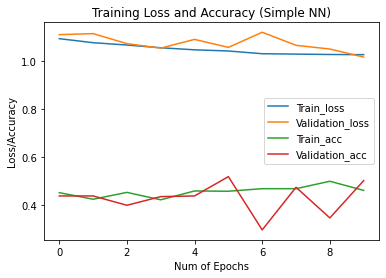

In [ ]:
N = np.arange(0, EPOCHS)
plt.figure(0)
plt.plot(N, snn.history["loss"], label="Train_loss")
plt.plot(N, snn.history["val_loss"], label="Validation_loss")
plt.plot(N, snn.history["acc"], label="Train_acc")
plt.plot(N, snn.history["val_acc"], label="Validation_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Num of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(curvas[0]+'/modelo_snn')

Ahora guardemos copia del modelo para su uso futuro.

In [ ]:
snn_model.save(output[0]+'/modelo_snn1')
f = open(etique[0]+'/label_bin', "wb")
f.write(pickle.dumps(lb))
f.close()

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/deep-learning/notebooks/model/modelo_snn1/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/deep-learning/notebooks/model/modelo_snn1/assets


## Herramientas para evaluación del modelo: Matriz de confusión y Curva ROC

### Matriz de confusión usando Scikit Learn

Una vez se ha entrenado el modelo, es posible ver otras métricas. Para ello, crearemos la matriz de confusión y, a partir de ella, veremos las métricas **precission**, **recall** y **F1-score**.

Vamos a hacer una predicción sobre el dataset de validación y, a partir de ésta, generamos la matriz de confusión y mostramos las métricas mencionadas anteriormente.

In [ ]:
snn_pred = snn_model.predict(x_test, batch_size=32, verbose=1)
snn_predicted = np.argmax(snn_pred, axis=1)

12/12 [==============================] - 0s 2ms/step


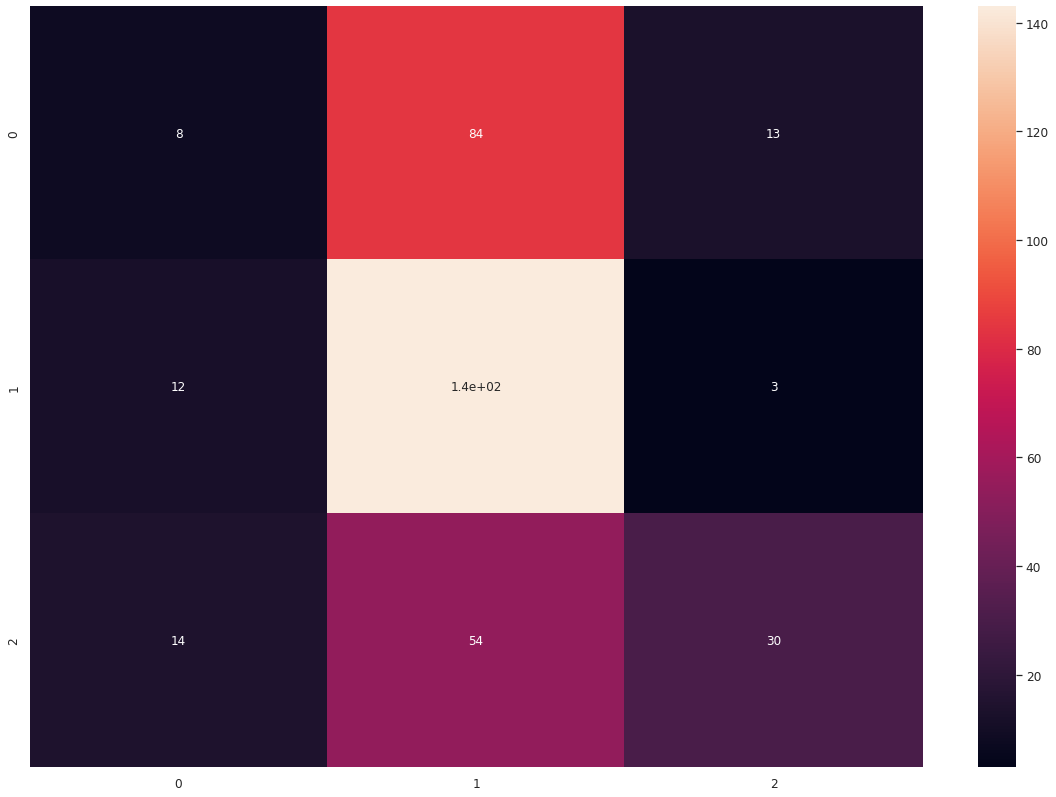

In [ ]:
# Creamos la matriz de confusión
snn_cm = confusion_matrix(np.argmax(y_test, axis=1), snn_predicted)

# Visualiamos la matriz de confusión
snn_df_cm = pd.DataFrame(snn_cm, range(len(lb.classes_)), range(len(lb.classes_)))
plt.figure(figsize = (20,14))
sn.set(font_scale=1.1) # Para el tamaño de las etiquetas
sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # Tamaño de la fuente
plt.show()

Y por último, mostramos las métricas:

In [ ]:
snn_report = classification_report(np.argmax(y_test, axis=1), snn_predicted)
print(snn_report)

              precision    recall  f1-score   support

           0       0.24      0.08      0.12       105
           1       0.51      0.91      0.65       158
           2       0.65      0.31      0.42        98

    accuracy                           0.50       361
   macro avg       0.47      0.43      0.39       361
weighted avg       0.47      0.50      0.43       361



### Curva ROC (Receiver Operator Characteristic, tasas de verdaderos positivos y falsos positivos)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


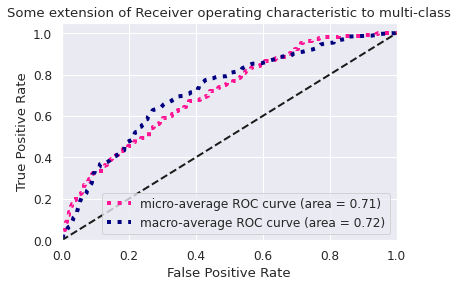

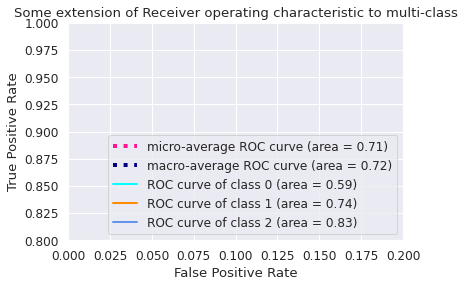

In [ ]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes = len(lb.classes_)

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

La segunda grafica muestra el área bajo cada curva, la mejor categorización se consigue con las áreas más grandes (azul).

Finalmente, vamos a ver algunos resultados. Miremos algunos elementos de prueba:

In [ ]:
y_test

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

Es decir, los tres primeros son: dogs, panda y panda (0, 2 y 2). Y los tres ultimos son: panda, bird, bird (2, 1 y 1). Miremos como los redice la red:

In [ ]:
print('Categoria para la imagen: ' + str(np.argmax(y_test[0])))
print('Categoria estimada:         ' + str(snn_predicted[0]))

Categoria para la imagen: 0
Categoria estimada:         1


In [ ]:
print('Categoria para la imagen: ' + str(np.argmax(y_test[1])))
print('Categoria estimada:         ' + str(snn_predicted[1]))

Categoria para la imagen: 2
Categoria estimada:         1


In [ ]:
print('Categoria para la imagen: ' + str(np.argmax(y_test[2])))
print('Categoria estimada:         ' + str(snn_predicted[2]))

Categoria para la imagen: 2
Categoria estimada:         0


Y las tres últimas:

In [ ]:
print('Categoria para la imagen: ' + str(np.argmax(y_test[len(y_test)-3])))
print('Categoria estimada:         ' + str(snn_predicted[len(y_test)-3]))

Categoria para la imagen: 2
Categoria estimada:         2


In [ ]:
print('Categoria para la imagen: ' + str(np.argmax(y_test[len(y_test)-2])))
print('Categoria estimada:         ' + str(snn_predicted[len(y_test)-2]))

Categoria para la imagen: 1
Categoria estimada:         1


In [ ]:
print('Categoria para la imagen: ' + str(np.argmax(y_test[len(y_test)-1])))
print('Categoria estimada:         ' + str(snn_predicted[len(y_test)-1]))

Categoria para la imagen: 1
Categoria estimada:         1


Las carpetas de salida contienen tres tipos de archivos que son generados por el entrenamiento:

- model_snn : Se genera un archivo de modelo Keras serializado después del entrenamiento y puede ser usado en futuros scripts de inferencia.
- label_bin : Un archivo binario de etiquetas serializado. Este archivo contiene un objeto que contiene nombres de clase. Acompaña a un archivo modelo.
- modelo_snn.png : Las imágenes de la gráfica de entrenamiento/validación en la carpeta de salida, utiles cuando se esta evaluando un modelo, como resultado del proceso de entrenamiento.

### Predicciones sobre nuevas imagenes utilizando el modelo entrenado

Es necesario importar explícitamente *load_model* desde *keras.models* cada vez que se escriba un script para cargar un modelo de Keras desde el disco duro. OpenCV se utilizará para la anotación y la visualización. El módulo pickle se utilizará para cargar las etiquetas binarias.

In [ ]:
images[0]

'/content/drive/My Drive/Colab Notebooks/deep-learning/notebooks/test_ani'

In [ ]:
from keras.models import load_model
import pickle
import cv2

image = cv2.imread(images[0]+'/xxx.jpg') # Nombre de la imagen a evaluar
image = cv2.resize(image, (norm_size, norm_size))
image = image.astype("float") / 255.0

image = image.flatten() # Al mismo formato plano con el que diseñamoa la red
image = image.reshape((1, image.shape[0]))

A partir de ahí, carguemos el modelo y la etiqueta binaria en la memoria y hagamos una predicción:

In [ ]:
model = load_model(output[0]+'/modelo_snn')
lb = pickle.loads(open(etique[0]+'/label_bin', "rb").read())
 
preds = model.predict(image)
 
# Encuentra la etiqueta de la categoría con la probabilidad mas alta
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]

¿Cuál es el resultado de la predicción?

In [ ]:
preds

array([[0.31223205, 0.29240116, 0.39536676]], dtype=float32)

Es decir, existe una probabilidad de:
- 22% de que sea la primera categoría (dogs).
- 49% de que sea la segunda categoría (bird).
- 29% de que sea la tercera categoría (panda).

Es decir, el clasificador piensa que se trata de un perro, aunque existe alguna probabilidad de ser pajaro o panda.

In [ ]:
text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
text

'panda: 39.54%'